# Graphs in ML - Project Notebook
###### Valentin Berkes, Simon Lebastard

In this notebook we will create several strongly and weakly connected graphs, test the Exp3G algorithm and assess the influence of a qualitative change in the connectivity graph on the evolution of regret.

In [1]:
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import write_dot
from networkx.algorithms.approximation import *
from EXP3 import EXP3, EXP3Opt, compute_regret, plot_regret, gaussian_filter
import arms
import numpy as np
import obsGraph
import pdb

In [2]:
G = nx.DiGraph()
G.add_node(0, arm=arms.ArmBernoulli(0.5))
G.add_node(1, arm=arms.ArmBernoulli(0.3))
G.add_node(2, arm=arms.ArmBernoulli(0.4))
G.add_node(3, arm=arms.ArmBernoulli(0.7))
G.add_edge(0,0)
G.add_edge(0,1)
G.add_edge(2,2)
G.add_edge(3,3)

G = nx.convert_node_labels_to_integers(G)

/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

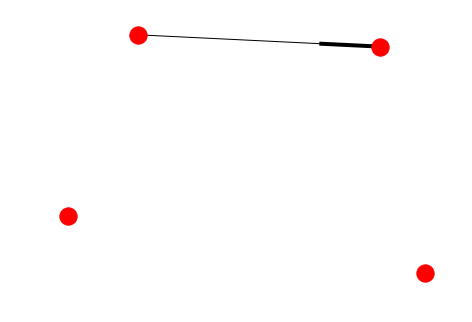

In [3]:
import matplotlib.pyplot as plt
nx.draw(G)  # networkx draw()
plt.draw()
plt.show()

In [4]:
## Get nice graphs with self-loops in PNG format
# 1) Install pygraphviz
# 2) Run:
write_dot(G,'graph.dot')
# 3) In terminal, run: dot -Tpng graph.dot > graph.png

We will run the Exp3G algorithm 50 times and produce an average to have a smooth regret function. This will allow us to detect quasi-linear components and better identify the asymptotic regret. Note that quasi-linear components can be used on a transformed regret:
- $x \mapsto \sqrt{x}$ would allow us to find the areas where the regret behaves as $\mathcal{O}(\sqrt{x})$
- $x \mapsto x^{\frac{2}{3}}$ would allow us to find the areas where the regret behaves as $\mathcal{O}(x^{\frac{2}{3}})$

In [4]:
n_itr = 5000
n_sim = 50

# q,losses = EXP3(G, list(G.nodes()), 0.5, 0.05, n_itr, n_sim)
q,losses = EXP3Opt(G, list(G.nodes()), n_itr, n_sim)

Simulating EXP3 on 50 runs: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


In [5]:
regret = compute_regret(losses, G)

Fitting power functions is still experimental, but it will allow us to track changes in regret trends when it fully works.
Note that we could better fit by knowing the independence number $\alpha(G)$ for strongly connected graphs, or the weak domination number $\delta(G)$ for weakly connected graphs. Determining those values is NP-hard, so no scalable method will be available, but there are some algorithms for computing approximations for small graphs. See for instance (Fox & Pach)

Found Pwr2/3 domain  1 at [   1, 2725]: Slope 2.86, intercept -473.32
Found Pwr2/3 domain  2 at [2727, 2792]: Slope 2.01, intercept 1772.29


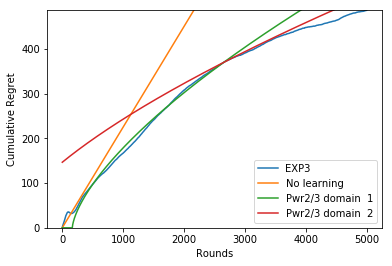

In [14]:
der2,linAreas = plot_regret(G, [regret], ['EXP3'], reg="Pwr2/3", stdev=34)
# der2,linAreas = plot_regret([regret], ['EXP3'])

Second derivative can be plotted to figure out the thresholds to use for fitting linear and power curves

In [9]:
#plt.plot(range(10,4700), der2[10:4700])
#plt.show()

## Building strongly connected graphs

To generate a class of strongly connected graphs, we use a parametric method that proceeds as follows:
- A fully connected graph $\mathcal{G}$ is created
- $\alpha \in [0,1]$ specifies the rate of self-edges to be removed from $\mathcal{G}$
- $\beta \in [0,1]$ parametrises the rate of peer-edges to be removed, according to the following policy: if we decide to remove peer-edges for a node $i$ then there is a uniform probability distribution over the number of peer-edges to remove.

Even though this method does allow to generate only a given class of graphs, we can later generalize it by introducing a third parameter $p$ that would be the probability distribution to replace the uniform distribution in the case where peer-edges are removed.

Here is an example of a strongly connected graph created through our function:

In [10]:
alpha1 = 0.5
beta1 = 0.5
n_nodes = 5
H1 = obsGraph.strong_obs_graph(n_nodes, alpha1, beta1)

/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

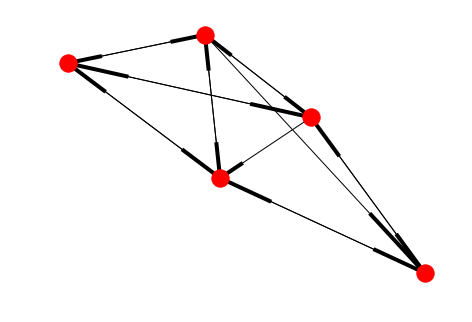

In [11]:
nx.draw(H1)  # networkx draw()
plt.draw()
plt.show()
write_dot(H1,'strong1.dot')

In [12]:
obsGraph.observability_type(H1)

2

In [13]:
obsGraph.strong_nodes(H1)

{'dual': [], 'peer': [3], 'self': [0, 1, 2, 4]}

Note that in this case, we chose $\alpha + \beta = 1$, resulting in edges removed for all nodes (either self-edge, or one or more peer-edges).

In the second example below, some edges are left dual:

/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

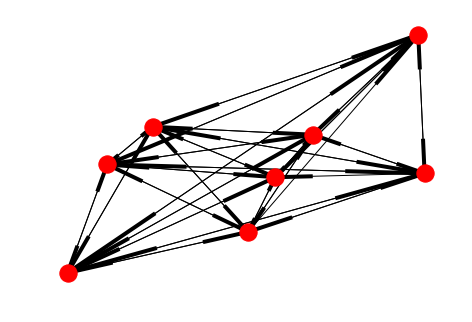

{'dual': [1, 2], 'peer': [0, 3, 5, 7], 'self': [4, 6]}

In [14]:
alpha2 = 0.4
beta2 = 0.3
n_nodes = 8
H2 = obsGraph.strong_obs_graph(n_nodes, alpha2, beta2)
nx.draw(H2)  # networkx draw()
plt.draw()
plt.show()
write_dot(H2,'strong2.dot')
obsGraph.observability_type(H2)
obsGraph.strong_nodes(H2)

# Examples
## Strongly observable
### Bandit

In [15]:
bandit = nx.DiGraph()
bandit.add_node(0, arm=arms.ArmBernoulli(0.5))
bandit.add_node(1, arm=arms.ArmBernoulli(0.3))
bandit.add_node(2, arm=arms.ArmBernoulli(0.4))
bandit.add_node(3, arm=arms.ArmBernoulli(0.7))
bandit.add_node(4, arm=arms.ArmBernoulli(0.1))
bandit.add_edge(0,0)
bandit.add_edge(1,1)
bandit.add_edge(2,2)
bandit.add_edge(3,3)
bandit.add_edge(4,4)
print(obsGraph.observability_type(bandit))

2


/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

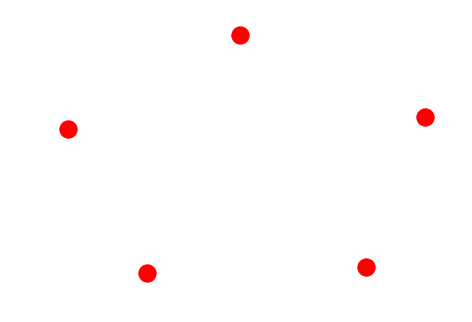

In [16]:
nx.draw(bandit)
plt.draw()
plt.show()
# Note that networkx does not display self edges
# Exporting the dot graph allows to see self-edges

In [39]:
n_itr = 5000
n_sim = 50
bandit_q, bandit_losses = EXP3(bandit, list(bandit.nodes()), 0.5, 0.05, n_itr, n_sim)
bandit_regret = compute_regret(bandit_losses, bandit)

Simulating EXP3 on 50 runs: 100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


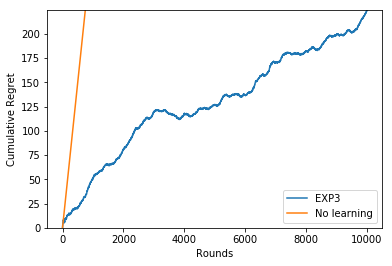

([], [])

In [18]:
plot_regret(bandit, [bandit_regret], ['EXP3'])

In [19]:
bandit_q

array([  2.00451723e-271,   4.68231003e-301,   1.06757068e-261,
         1.00000000e+000,   8.89318163e-323])

independent set np hard
https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.approximation.html?highlight=independent%20set#module-networkx.algorithms.approximation.independent_set

how to compute weak domination number?

regret doit être une esperance: il faut lancer plusieurs fois et faire la moyenne

### Full feedback

In [20]:
graph_arms = [arms.ArmBernoulli(0.5), arms.ArmBernoulli(0.3), arms.ArmBernoulli(0.4), arms.ArmBernoulli(0.7), arms.ArmBernoulli(0.1)]
full_feedback = obsGraph.strong_obs_graph(5, 0, 0, graph_arms)
print(obsGraph.observability_type(full_feedback))

2


/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

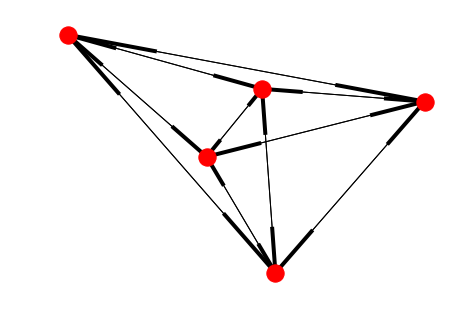

In [21]:
nx.draw(full_feedback)  # networkx draw()
plt.draw()
plt.show()

In [40]:
n_itr = 5000
n_sim = 50
full_feedback_q, full_feedback_losses = EXP3(full_feedback, list(full_feedback.nodes()), 0.5, 0.05, n_itr, n_sim)
full_feedback_regret = compute_regret(full_feedback_losses, full_feedback)

Simulating EXP3 on 50 runs: 100%|██████████| 50/50 [00:15<00:00,  3.30it/s]


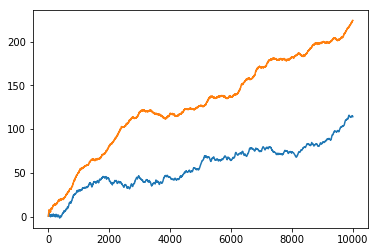

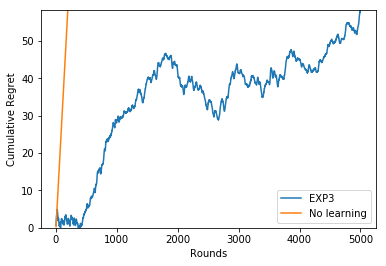

([], [])

In [41]:
plot_regret(full_feedback, [full_feedback_regret], ['EXP3'])

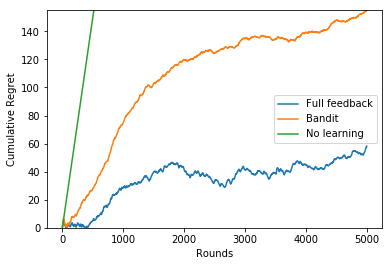

([], [])

In [46]:
plot_regret(full_feedback, [full_feedback_regret, bandit_regret], ['Full feedback', 'Bandit'])

### Police officer - loopless clique

In [43]:
graph_arms = [arms.ArmBernoulli(0.5), arms.ArmBernoulli(0.3), arms.ArmBernoulli(0.4), arms.ArmBernoulli(0.7), arms.ArmBernoulli(0.1)]
police = obsGraph.strong_obs_graph(5, 1, 0, graph_arms)
print(obsGraph.observability_type(police))

2


/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

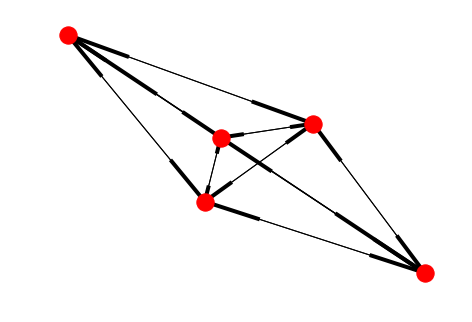

In [44]:
nx.draw(police)  # networkx draw()
plt.draw()
plt.show()

In [48]:
n_itr = 5000
n_sim= 50
police_q, police_losses = EXP3(police, list(police.nodes()), 0.5, 0.05, n_itr, n_sim)
police_regret = compute_regret(police_losses, police)

Simulating EXP3 on 50 runs: 100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


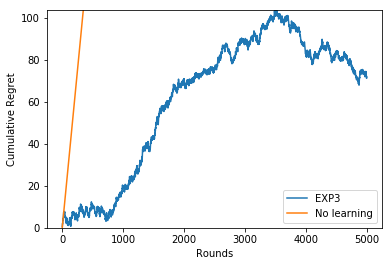

([], [])

In [49]:
plot_regret(police, [police_regret], ['EXP3'])

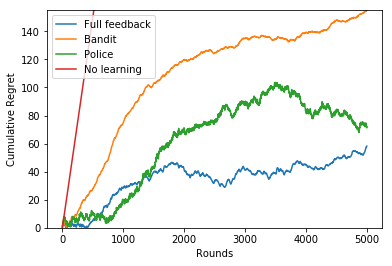

([], [])

In [50]:
plot_regret(police, [full_feedback_regret, bandit_regret, police_regret], ['Full feedback', 'Bandit', 'Police'])

## Weakly observable

### Revealing actions

In [13]:
revealing = nx.DiGraph()
revealing.add_node(0, arm=arms.ArmBernoulli(0.5))
revealing.add_node(1, arm=arms.ArmBernoulli(0.3))
revealing.add_node(2, arm=arms.ArmBernoulli(0.4))
revealing.add_node(3, arm=arms.ArmBernoulli(0.7))
revealing.add_node(4, arm=arms.ArmBernoulli(0.1))
revealing.add_edge(0,0)
revealing.add_edge(0,1)
revealing.add_edge(0,2)
revealing.add_edge(0,3)
revealing.add_edge(0,4)
print(obsGraph.observability_type(revealing))

1


/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

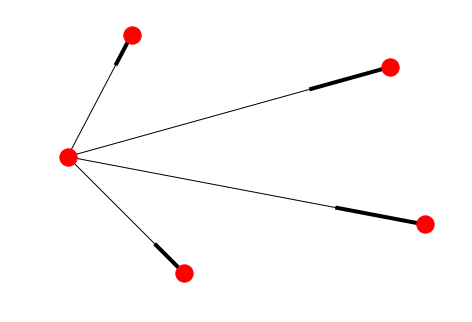

In [14]:
nx.draw(revealing)  # networkx draw()
plt.draw()
plt.show()

In [15]:
n_itr = 10000
n_sim = 10
revealing_q, revealing_losses = EXP3(revealing, list(revealing.nodes()), 0.5, 0.05, n_itr, n_sim)
revealing_regret = compute_regret(revealing_losses, revealing)

Simulating EXP3 on 10 runs:   0%|          | 0/10 [00:00<?, ?it/s]

G is weakly observable


Simulating EXP3 on 10 runs: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


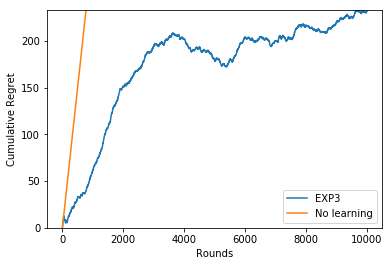

([], [])

In [16]:
plot_regret(revealing, [revealing_regret], ['EXP3'])

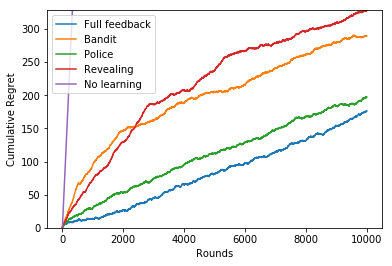

([], [])

In [37]:
plot_regret(revealing, [full_feedback_regret, bandit_regret, police_regret, revealing_regret], ['Full feedback', 'Bandit', 'Police','Revealing'])

## Unobservable

# Instability

## Strongly to weakly

Here we will build a strongly connected graph, run Exp3G on this graph but break the strong connectivity while the algorithm runs.
Let's start simple with 5 nodes. The graph will only contain peer-edges

In [8]:
alpha1 = 1
beta1 = 0
n_nodes = 5
S1 = obsGraph.strong_obs_graph(n_nodes, alpha1, beta1)

/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/proprietaire/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/proprietaire/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

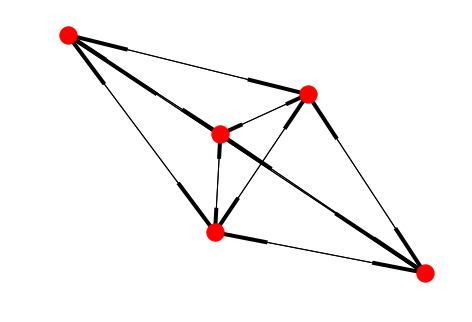

In [9]:
nx.draw(S1)  # networkx draw()
plt.draw()
plt.show()

In [10]:
perturbations = {1000:[(0,1)], 2000:[(0,2),(1,2)]}
n_itr = 5000
n_sim = 10

obsGraph.observability_type(S1)

2

In [ ]:
qS1,lS1 = EXP3(S1, list(S1.nodes()), 0.5, 0.05, n_itr, n_sim)
regS1 = compute_regret(lS1, G)
dr2S1,laS1 = plot_regret(S1, [regS1], ['EXP3 on strong graph'])

W1 = S1.remove_edge(0,1)
qW1,lW1 = EXP3(W1, list(W1.nodes()), 0.5, 0.05, n_itr, n_sim)
regW1 = compute_regret(lW1, G)
dr2W1,laW1 = plot_regret(W1, [regW1], ['EXP3 on weakly connected graph'])

> /home/proprietaire/Documents/Workspace/School/MVA/GraphsML/Projet/Git/EXP3.py(14)EXP3()
-> print("G is {}".format(obs_dict[obs_type]))
(Pdb) args
G = <networkx.classes.digraph.DiGraph object at 0x7f96df7cfcc0>
U = [0, 1, 2, 3, 4]
eta = 0.5
gamma = 0.05
T = 5000
n_sim = 10
perturbations = None


## Strongly to unobservable

In [11]:
# Should transition toweakly observable at 1000th iteration, then to unobservable at 2000th iteration
perturbations = {1000:[[0,1]], 2000:[[0,2],[0,3],[0,4]]}

## Weakly to unobservable

## Bibliography

Fox & Pach, Computing the Independence Number of Intersection Graphs, math.mit.edu/~fox/paper-foxj.pdf